In [46]:
%matplotlib inline
import os
seed = 42
os.environ['PYTHONHASHSEED']=str(seed)

import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import GroupShuffleSplit

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Masking, TimeDistributed
from tensorflow.keras.preprocessing.sequence import pad_sequences

random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

#### Utility Functions

In [47]:
# get the RMSE of the results
def get_rmse(y_real, y_hat, label='test'):
    mse = mean_squared_error(y_real, y_hat)
    rmse = np.sqrt(mse)
    variance = r2_score(y_real, y_hat)
    print('Dataset: {} RMSE:{}, R2:{}'.format(label, rmse, variance))

# adds the operating condition for the engine for each unit
# make a string to use as categorical variable
def add_op_co(df):
    op_co = df.copy()
    op_co['setting_1'] = op_co['setting_1'].round(decimals=2)
    op_co['setting_2'] = op_co['setting_2'].round(decimals=2)
    op_co['setting_3'] = op_co['setting_3'].round(decimals=2)
    op_co['op_cond'] = op_co['setting_1'].astype(str) + '-' + op_co['setting_2'].astype(str) + '-' + op_co['setting_3'].astype(str)
    return op_co

def condition_scaler(df_train, df_test, sensor_names):
    # apply operating condition specific scaling
    scaler = StandardScaler()
    for condition in df_train['op_cond'].unique():
        scaler.fit(df_train.loc[df_train['op_cond']==condition, sensor_names])
        df_train.loc[df_train['op_cond']==condition, sensor_names] = scaler.transform(df_train.loc[df_train['op_cond']==condition, sensor_names])
        df_test.loc[df_test['op_cond']==condition, sensor_names] = scaler.transform(df_test.loc[df_test['op_cond']==condition, sensor_names])
    return df_train, df_test

# need to remove noise from the signals or the LSTM is gonna be a mess
# https://machinelearningmastery.com/exponential-smoothing-for-time-series-forecasting-in-python/
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.ewm.html
# https://stackoverflow.com/questions/60966612/how-to-use-exponential-smoothing-to-smooth-the-timeseries-in-python
# https://stackoverflow.com/questions/36511942/exponential-smoothing-function-issue-with-grouping-sizes

def exponential_smoothing(df, sensors, n_samples, alpha=0.4):
    df = df.copy()
    # first, calculate the exponential weighted mean of desired sensors
    df[sensors] = df.groupby('unit_id')[sensors].apply(lambda x: x.ewm(alpha=alpha).mean())
    
    # second, drop first n_samples of each unit_id to reduce filter delay
    def create_mask(data, samples):
        result = np.ones_like(data)
        result[0:samples] = 0
        return result
    
    mask = df.groupby('unit_id')['unit_id'].transform(create_mask, samples=n_samples).astype(bool)
    df = df[mask]
    
    return df

In [48]:
# sequence array generator for LSTM

# need to generate sequences for the LSTM to use
# Tensorflow has some functions for this, but not flexible enough to use with our dataset
# need custom generator because not all engines have sequences of the same size
# code adapted from --> https://github.com/Azure/lstms_for_predictive_maintenance
# https://realpython.com/introduction-to-python-generators/

def gen_train_seq(data, sequence_length, cols):
    data_out = data[cols].values
    size = data_out.shape[0]
    for start, stop in zip(range(0, size - (sequence_length-1)), range(sequence_length, size+1)):
        yield data_out[start:stop, :]
          
def label_generator(data, sequence_length, labels):
    data_out = data[labels].values
    size = data_out.shape[0]
    return data_out[sequence_length-1:size, :]

def test_padding(data, sequence_length, cols, m):
    size = data.shape[0]
    
    if size < sequence_length: # add padding of dummy nums
        padding = np.full(shape = ((sequence_length - size), len(cols)), fill_value = m)
        output = np.concatenate((padding, data[cols].values))
    else:
        output = data[cols].values
    
    # per predictive maintenance template we only want the last sequence from each test run
    #(https://gallery.azure.ai/Experiment/Predictive-Maintenance-Step-1-of-3-data-preparation-and-feature-engineering-2),
    
    stop = output.shape[0]
    start = stop - sequence_length
    
    for i in list(range(1)):
        yield(output[start:stop,:])
        
        

In [49]:
# import dataset!

dataset = "002"

training_file = 'CMAPSS_DATA/train_FD{}.txt'.format(dataset)
testing_file = 'CMAPSS_DATA/test_FD{}.txt'.format(dataset)
RUL_file = 'CMAPSS_DATA/RUL_FD{}.txt'.format(dataset)
index_names = ['unit_id', 'time_cycles']
setting_names = ['setting_1', 'setting_2', 'setting_3']
sensor_names = ['s_{}'.format(i+1) for i in range(0,21)]
col_names = index_names + setting_names + sensor_names


train = pd.read_csv(training_file, sep='\s+', header=None, 
                 names=col_names)
test = pd.read_csv(testing_file, sep='\s+', header=None, 
                 names=col_names)
y_test = pd.read_csv(RUL_file, sep='\s+', header=None, 
                 names=['RemainingUsefulLife'])

print(train.shape)
train.head()


(53759, 26)


,unit_id,time_cycles,setting_1,setting_2,setting_3,s_1,s_2,s_3,s_4,s_5,...,s_12,s_13,s_14,s_15,s_16,s_17,s_18,s_19,s_20,s_21
0,1,1,34.9983,0.8400,100.0,449.44,555.32,1358.61,1137.23,5.48,...,183.06,2387.72,8048.56,9.3461,0.02,334,2223,100.00,14.73,8.8071
1,1,2,41.9982,0.8408,100.0,445.00,549.90,1353.22,1125.78,3.91,...,130.42,2387.66,8072.30,9.3774,0.02,330,2212,100.00,10.41,6.2665
2,1,3,24.9988,0.6218,60.0,462.54,537.31,1256.76,1047.45,7.05,...,164.22,2028.03,7864.87,10.8941,0.02,309,1915,84.93,14.08,8.6723
3,1,4,42.0077,0.8416,100.0,445.00,549.51,1354.03,1126.38,3.91,...,130.72,2387.61,8068.66,9.3528,0.02,329,2212,100.00,10.59,6.4701
4,1,5,25.0005,0.6203,60.0,462.54,537.07,1257.71,1047.93,7.05,...,164.31,2028.00,7861.23,10.8963,0.02,309,1915,84.93,14.13,8.5286


In [50]:
# need to attach the RUL for each cycle

# Get the max num of cycles for each unit & add to dataframe
group_by_unit = train.groupby(by="unit_id")
max_cycle = group_by_unit["time_cycles"].max()
RUL_column = train.merge(max_cycle.to_frame(name='max_cycle'), left_on='unit_id', right_index=True)
# for each row, get the difference from it to the max
remaining_useful_life = RUL_column["max_cycle"] - RUL_column["time_cycles"]
RUL_column["RUL"] = remaining_useful_life
# get rid of the max, dont need anymore
train = RUL_column.drop("max_cycle", axis=1)
train[index_names+['RUL']].head()

,unit_id,time_cycles,RUL
0,1,1,148
1,1,2,147
2,1,3,146
3,1,4,145
4,1,5,144


### Step 1: Try regular old regression!

In [51]:
# build up data for training the models

X_train = train[setting_names + sensor_names].copy()
y_train = train['RUL'].copy()
y_train_clipped = y_train.clip(upper=125)

# get last row of each engine
X_test = test.drop('time_cycles', axis=1).groupby('unit_id').last().copy() 

In [52]:


# create and fit model
lm = LinearRegression()
lm.fit(X_train, y_train)

# predict and evaluate
y_hat_train = lm.predict(X_train)
get_rmse(y_train, y_hat_train, 'train')

y_hat_test = lm.predict(X_test)
get_rmse(y_test, y_hat_test)

Dataset: train RMSE:45.02973737819622, R2:0.5763193277684202
Dataset: test RMSE:33.942725282220685, R2:0.6016440598063979


Results are pretty not great compared to the LSTM paper, so hopefully there will be a pretty big improvement!

In [9]:
X_train_condition = add_op_co(train)
X_test_condition = add_op_co(X_test)

X_train_condition_scaled, X_test_condition_scaled = condition_scaler(X_train_condition, X_test_condition, sensor_names)

X_train_condition.head()
X_train_condition

,unit_id,time_cycles,setting_1,setting_2,setting_3,s_1,s_2,s_3,s_4,s_5,...,s_14,s_15,s_16,s_17,s_18,s_19,s_20,s_21,RUL,op_cond
0,1,1,35.00,0.84,100.0,0.0,-1.092255,-1.428809,0.763529,-1.0,...,-1.528826,0.364324,1.000000,-0.172831,0.0,0.0,-0.895878,-1.342356,148,35.0-0.84-100.0
1,1,2,42.00,0.84,100.0,0.0,0.448552,-0.223472,-0.263521,1.0,...,-1.039320,0.063883,0.000000,-0.760405,0.0,0.0,-1.633779,-1.316234,147,42.0-0.84-100.0
2,1,3,25.00,0.62,60.0,0.0,1.244426,-1.110918,-0.420829,0.0,...,-1.035391,-0.459116,1.000000,1.272720,0.0,-1.0,-1.625728,1.718004,146,25.0-0.62-60.0
3,1,4,42.01,0.84,100.0,0.0,-0.446394,-0.070759,-0.189450,1.0,...,-1.266082,-0.590155,1.000000,-1.466264,0.0,0.0,0.028914,1.879583,145,42.01-0.84-100.0
4,1,5,25.00,0.62,60.0,0.0,0.572862,-0.932085,-0.350847,0.0,...,-1.311691,-0.408135,1.000000,1.272720,0.0,-1.0,-1.179735,-0.456893,144,25.0-0.62-60.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53754,260,312,20.00,0.70,100.0,1.0,2.627937,1.736544,2.086107,1.0,...,6.837505,1.797280,1.906925,2.430025,0.0,0.0,-0.697993,-1.910684,4,20.0-0.7-100.0
53755,260,313,10.00,0.25,100.0,-1.0,1.913566,2.148785,1.534235,1.0,...,7.044034,2.479261,-1.000000,2.910383,0.0,0.0,-2.998081,-2.001436,3,10.0-0.25-100.0
53756,260,314,25.00,0.62,60.0,0.0,1.720117,2.556088,1.105672,0.0,...,7.039556,3.517368,1.000000,2.042906,0.0,-1.0,-0.644544,-0.128464,2,25.0-0.62-60.0
53757,260,315,25.00,0.62,60.0,0.0,2.727463,1.936763,2.327456,0.0,...,7.132162,3.239293,1.000000,2.813092,0.0,-1.0,-1.893323,-2.813410,1,25.0-0.62-60.0


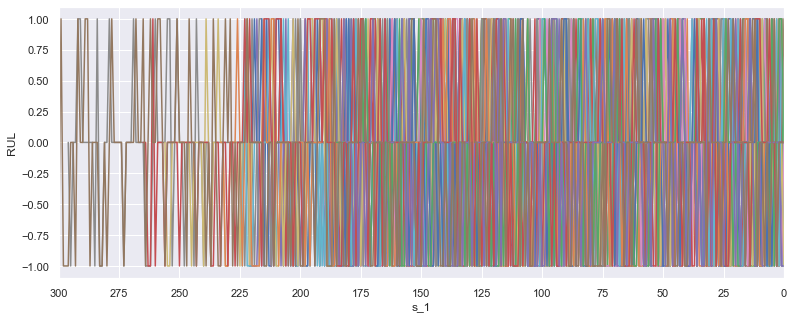

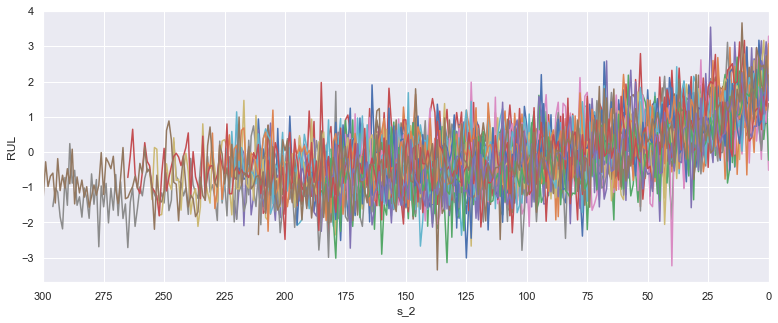

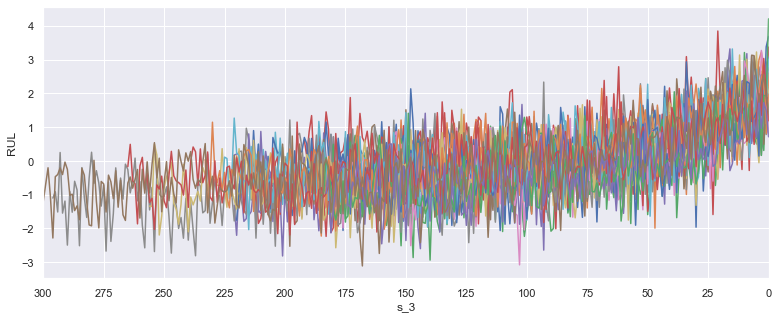

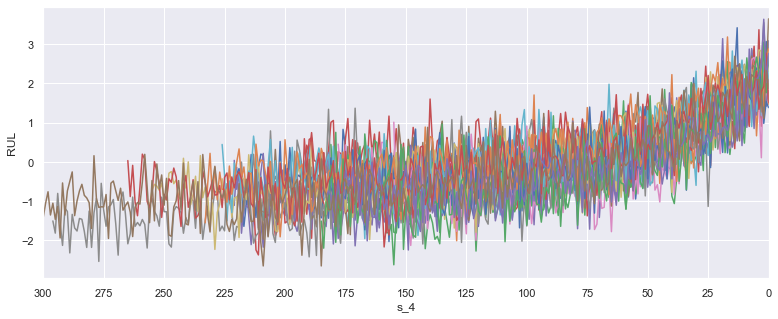

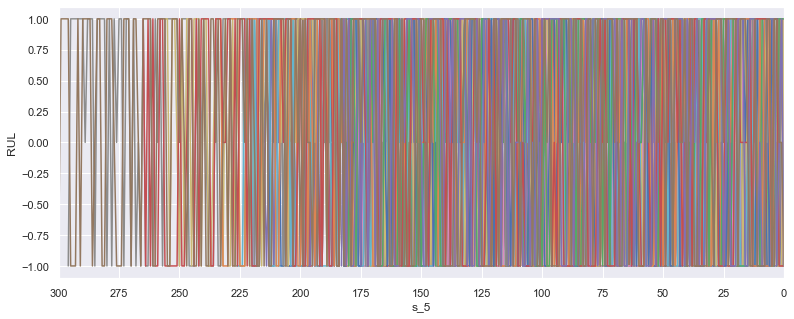

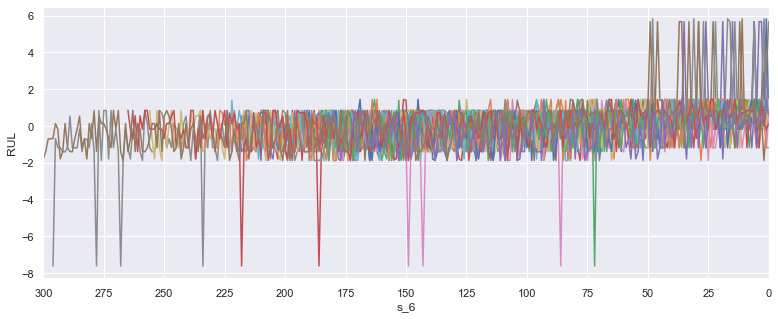

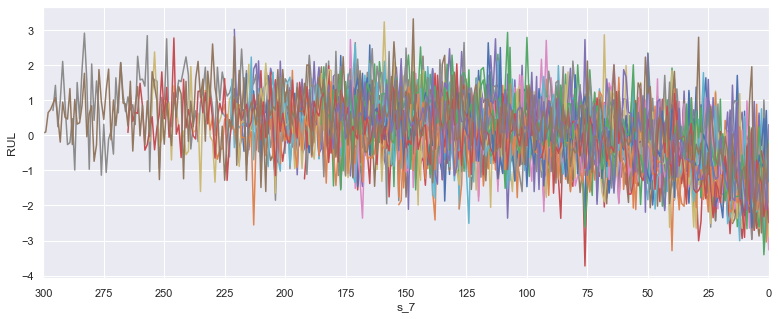

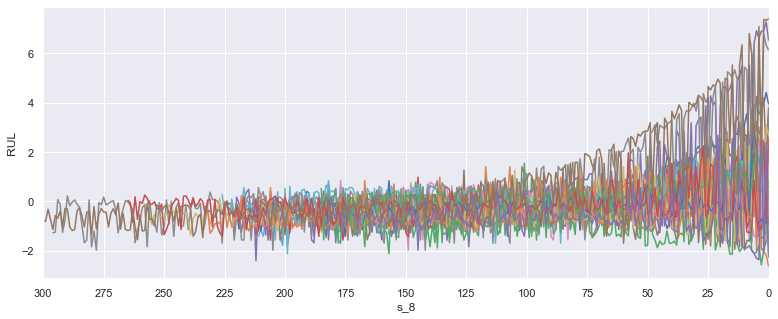

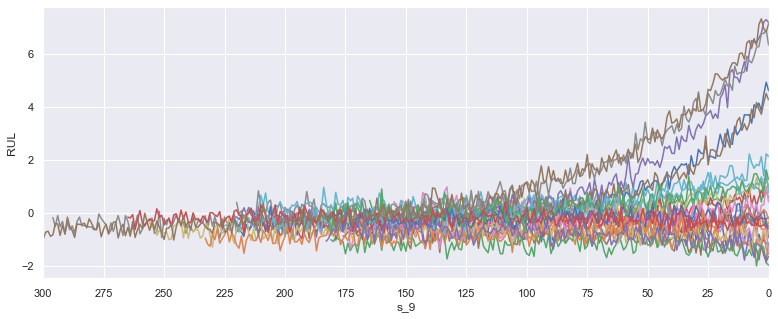

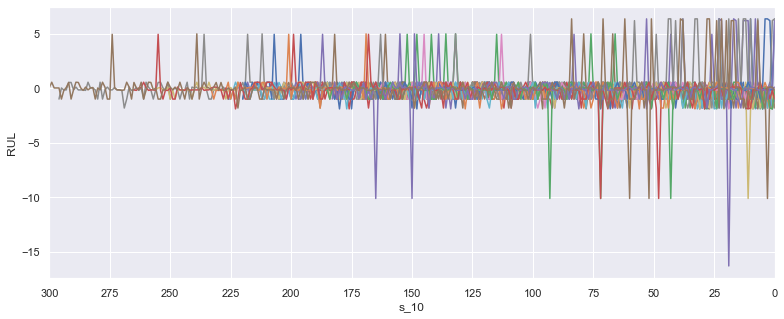

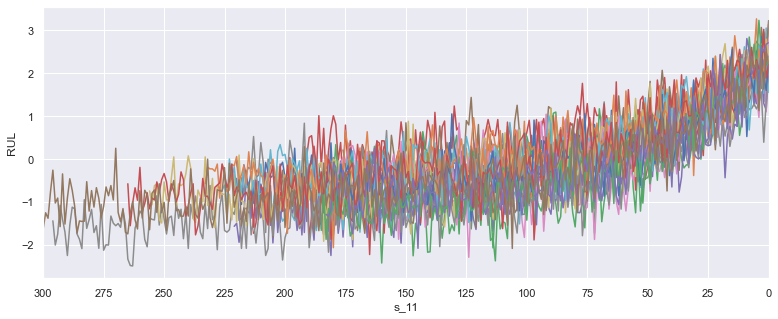

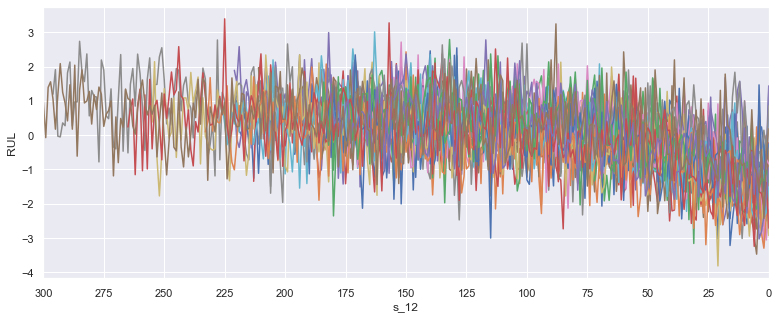

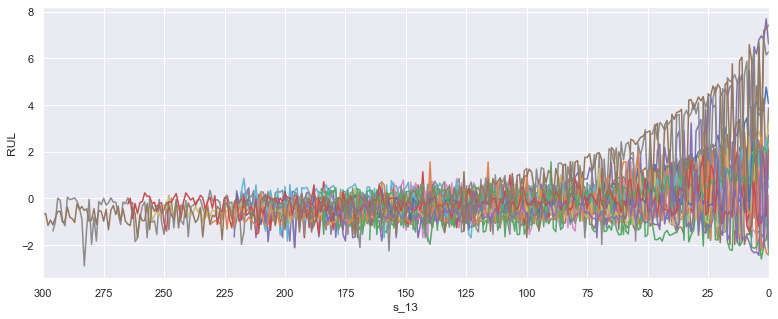

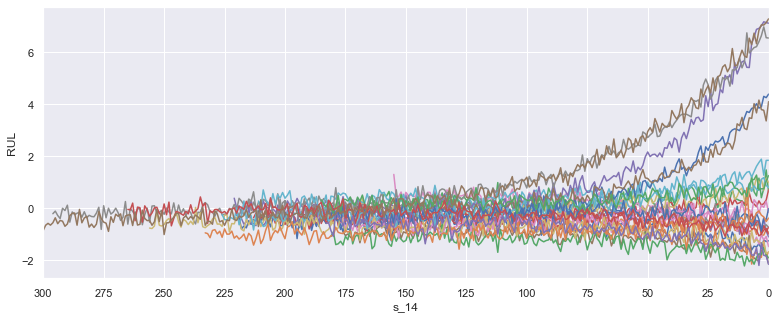

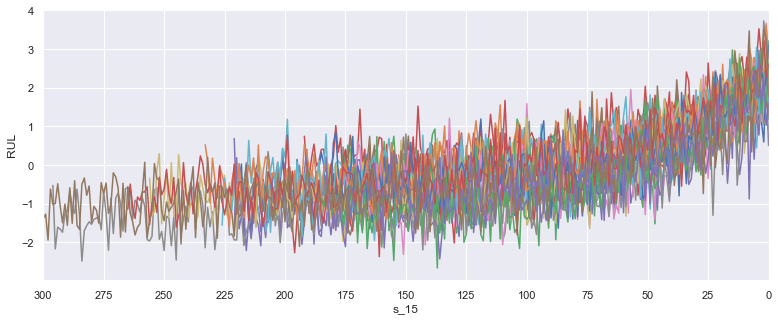

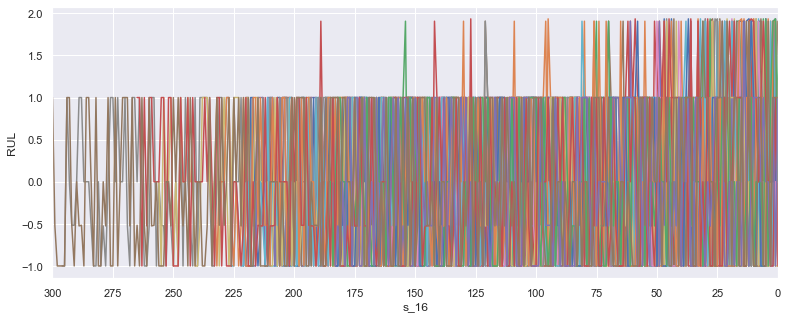

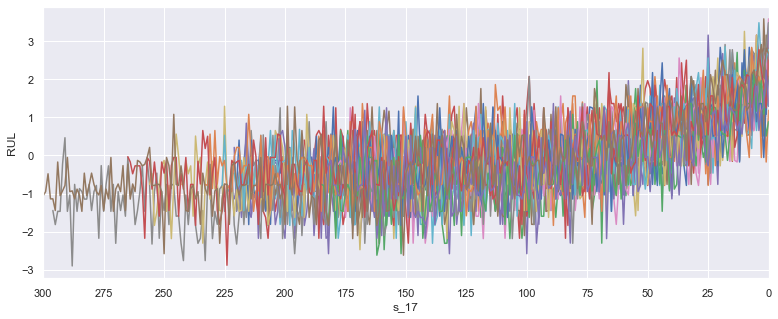

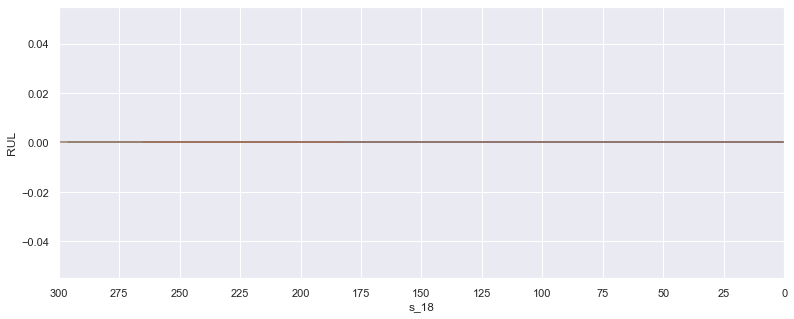

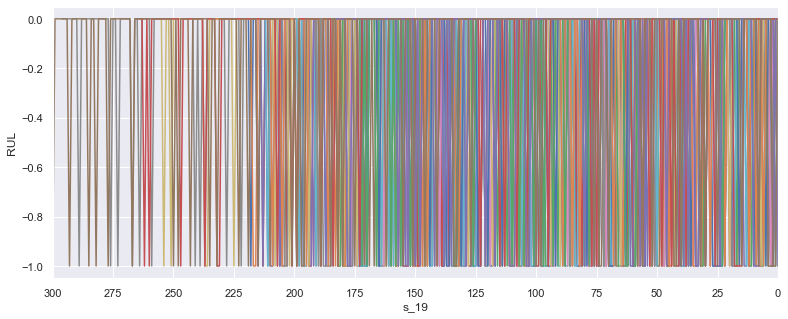

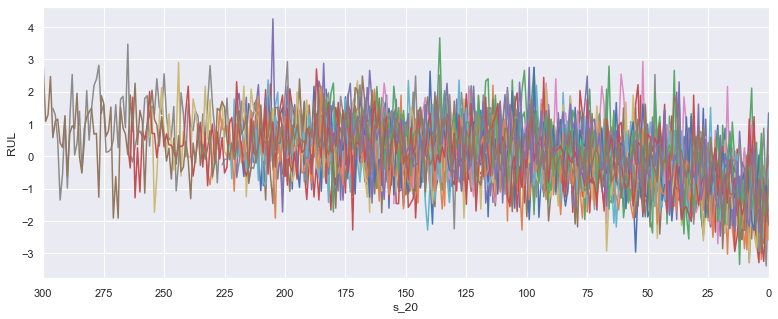

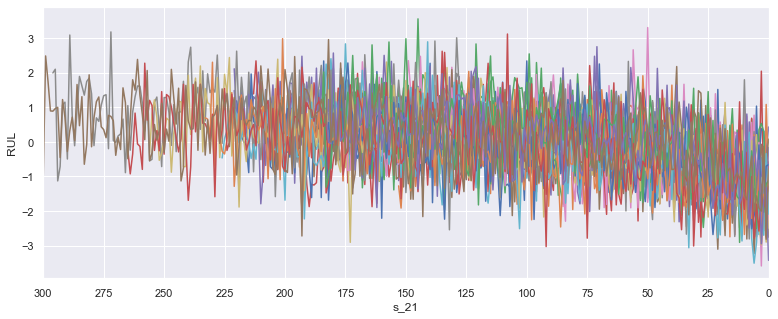

In [10]:
# plot each sensor to see if it seems useful at all

for sensor in sensor_names:
    plt.figure(figsize=(13,5))
    for i in train['unit_id'].unique():
        if (i % 10 == 0):
            plt.plot("RUL", sensor, data=X_train_condition_scaled[X_train_condition_scaled["unit_id"] == i])
    plt.xlim(300,0)
    plt.xlabel(sensor)
    plt.ylabel("RUL")
    plt.xticks(np.arange(0,325,25))
    plt.show()

Seonsors 1, 5, 6, 16, 18, and  seem to be pretty much just noise, so I am gonna drop em

In [11]:
drops = ['s_1', 's_5', 's_6', 's_10', 's_16', 's_18', 's_19']
keep = ['s_2', 's_3', 's_4', 's_7', 's_8', 's_9',
       's_11', 's_12', 's_13', 's_14', 's_15', 's_17', 's_20', 's_21']

In [53]:
# need to format data for LSTM model. I did my best, this part is kinda hard.
gss = GroupShuffleSplit(n_splits=1, train_size=0.80, random_state=42)
# so first we need to set how long our sequence is going to be
# in theory this is something we can play around with
sequence_length = 50

# also, added some clipping so that I don't capture steady state operations, and instead we are looking at degredation
train['RUL'].clip(upper=125, inplace=True)

# next, drop the columns we ain't gonna be using
train_dropped = train.drop(drops, axis=1)
test_dropped = test.drop(drops, axis=1)

# now, add operating condition as a string we can use as a conditional variable
# basically just combine the settings into a single string

train_dropped_co = add_op_co(train_dropped)
test_dropped_co = add_op_co(test_dropped)

# next we need to standardize the data
scaler = StandardScaler()



# using the condition to standardize. Initially just tried scaling everything, but this actually worked the best
for co in train_dropped_co['op_cond'].unique():
    scaler.fit(train_dropped_co.loc[train_dropped_co['op_cond']==co, keep])
    train_dropped_co.loc[train_dropped_co['op_cond']==co, keep] = scaler.transform(train_dropped_co.loc[train_dropped_co['op_cond']==co, keep])
    test_dropped_co.loc[test_dropped_co['op_cond']==co, keep] = scaler.transform(test_dropped_co.loc[test_dropped_co['op_cond']==co, keep])

# regular old scalar
train_dropped_co_reg_st = train_dropped_co.copy()
test_dropped_co_reg_st = test_dropped_co.copy()
for i in keep:
    train_dropped_co_reg_st[keep] = scaler.fit_transform(train_dropped_co[keep])
    test_dropped_co_reg_st[keep] = scaler.fit_transform(test_dropped_co[keep])

# minmax, which is what Azure team did

train_dropped_co_reg_mm = train_dropped_co.copy()
test_dropped_co_reg_mm = test_dropped_co.copy()
minmax = MinMaxScaler()
for i in keep:
    train_dropped_co_reg_mm[keep] = minmax.fit_transform(train_dropped_co[keep])
    test_dropped_co_reg_mm[keep] = minmax.fit_transform(test_dropped_co[keep])

# need to now split into train and validation sets. GSS is a pretty neat way to do it, given that we need to keep units intact (i.e. sequences stay within engine)
train_u = []
val_u = []
for train_index, val_index in gss.split(train_dropped_co['unit_id'].unique(), groups=train_dropped_co['unit_id'].unique()):
    train_u = [train_index]
    val_u = [val_index]

# these are the units we are gonna use in each split
train_units = train_dropped_co['unit_id'].unique()[train_u]
val_units = test_dropped_co['unit_id'].unique()[val_u]
print(train_units)

# now we need to shape the data into arrays and then sequences for the LSTM
# tried to use tensorflow, but it does not have enough flexibility to make the sequences
# since we need to keep engine data together

# define our feature columns:
# couple different ways to look at it

features_just_senors = keep
features_with_settings = setting_names.extend(keep)

# use generator to make generator for each engine, then wrap them up into a single generator

# first make validation testing sets

train_split_gen = (list(gen_train_seq(train_dropped_co[train_dropped_co["unit_id"]==u], sequence_length, features_just_senors)) for u in train_units)
train_split = np.concatenate(list(train_split_gen)).astype(np.float32)

val_split_gen = (list(gen_train_seq(train_dropped_co[train_dropped_co["unit_id"]==u], sequence_length, features_just_senors)) for u in val_units)
val_split = np.concatenate(list(val_split_gen)).astype(np.float32)

# lstm aslo requires labels for each sequence, which needs to be generated
# label is essentially the thing we are trying to predict or classify
# in Azure study, they classified based on if the engine would fail within x cycles
# since we are trying to predict RUL, we will use RUL

train_labels_gen = [label_generator(train_dropped_co[train_dropped_co["unit_id"]==u], sequence_length, ['RUL']) for u in train_units]
train_labels = np.concatenate(list(train_labels_gen)).astype(np.float32)

val_labels_gen = [label_generator(train_dropped_co[train_dropped_co["unit_id"]==u], sequence_length, ['RUL']) for u in val_units]
val_labels = np.concatenate(list(val_labels_gen)).astype(np.float32)

# Lastly, lets get the data for making predictions, using the full available dataset

train_gen = (list(gen_train_seq(train_dropped_co[train_dropped_co["unit_id"]==u], sequence_length, features_just_senors)) for u in train_dropped_co["unit_id"].unique())
train_array = np.concatenate(list(train_gen)).astype(np.float32)

train_labels_out_gen = [label_generator(train_dropped_co[train_dropped_co["unit_id"]==u], sequence_length, ['RUL']) for u in train_dropped_co["unit_id"].unique()]
train_array_labels = np.concatenate(list(train_labels_out_gen)).astype(np.float32)

# and now we need the test data
# in order to get more test data, we can add padding to get more sequences
# padding idea inspired by --> https://towardsdatascience.com/lstm-for-predictive-maintenance-of-turbofan-engines-f8c7791353f3

test_gen = (list(test_padding(test_dropped_co[test_dropped_co["unit_id"]==u], sequence_length, features_just_senors, -99.)) for u in test_dropped_co["unit_id"].unique())
test_array = np.concatenate(list(test_gen)).astype(np.float32)
sensor_names
data = train[sensor_names].values
len(data)

len(train_split)

<ipython-input-53-12b3cf785664>:55: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  train_units = train_dropped_co['unit_id'].unique()[train_u]
<ipython-input-53-12b3cf785664>:56: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  val_units = test_dropped_co['unit_id'].unique()[val_u]


[  1   2   3   4   5   6   8   9  12  13  14  15  17  18  21  22  23  24
  27  28  29  30  32  33  35  36  37  38  39  40  41  42  43  44  45  48
  49  50  51  52  53  54  55  56  57  58  59  60  61  62  63  64  65  66
  67  68  70  71  72  73  74  75  77  79  80  81  82  83  84  85  86  87
  88  89  90  92  94  95  96  99 100 101 103 104 106 107 108 109 110 111
 112 113 116 117 118 119 121 122 123 124 125 126 127 128 129 130 131 132
 133 134 135 136 137 138 139 141 142 144 146 147 148 149 150 152 153 154
 156 157 158 160 161 162 163 164 165 166 167 169 170 171 172 173 175 176
 177 179 181 183 184 185 187 188 189 190 192 193 194 195 196 198 199 200
 201 203 204 208 209 210 211 215 216 217 218 219 220 222 223 225 226 227
 228 230 231 232 233 234 235 236 239 240 241 242 244 245 246 247 248 249
 250 251 252 253 254 255 256 257 258 260]


33272

In [54]:
model = Sequential()
model.add(Masking(mask_value=-99., input_shape=(sequence_length, train_array.shape[2])))
model.add(LSTM(50, activation='tanh'))
model.add(Dropout(.5))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.save_weights('simple_lstm_weights_002_base.h5')

In [55]:
model.load_weights('simple_lstm_weights_002_base.h5')  # weights are reloaded to ensure reproducible results

history = model.fit(train_split, train_labels,
                    validation_data=(val_split, val_labels),
                    epochs=20,
                   batch_size=32)

Epoch 1/20
1040/1040 [==============================] - 94s 56ms/step - loss: 3765.1299 - val_loss: 1748.9341
Epoch 2/20
1040/1040 [==============================] - 33s 32ms/step - loss: 1284.3831 - val_loss: 603.6949
Epoch 3/20
1040/1040 [==============================] - 37s 35ms/step - loss: 573.3118 - val_loss: 285.3989
Epoch 4/20
1040/1040 [==============================] - 34s 33ms/step - loss: 389.4202 - val_loss: 202.6227
Epoch 5/20
1040/1040 [==============================] - 36s 35ms/step - loss: 337.9027 - val_loss: 178.0473
Epoch 6/20
1040/1040 [==============================] - 33s 32ms/step - loss: 326.3847 - val_loss: 180.4520
Epoch 7/20
1040/1040 [==============================] - 34s 33ms/step - loss: 320.3482 - val_loss: 169.1544
Epoch 8/20
1040/1040 [==============================] - 34s 33ms/step - loss: 306.9931 - val_loss: 166.7093
Epoch 9/20
1040/1040 [==============================] - 38s 36ms/step - loss: 303.5411 - val_loss: 179.7831
Epoch 10/20
1040/1040 [==

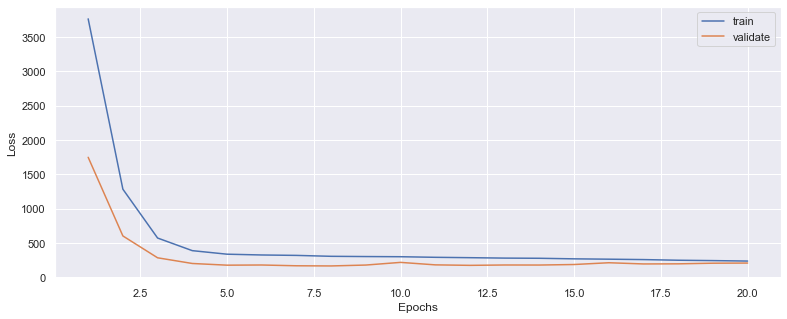

In [56]:
def plot_loss(fit_history):
    plt.figure(figsize=(13,5))
    plt.plot(range(1, len(fit_history.history['loss'])+1), fit_history.history['loss'], label='train')
    plt.plot(range(1, len(fit_history.history['val_loss'])+1), fit_history.history['val_loss'], label='validate')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

plot_loss(history)

In [57]:

# predict and evaluate
y_hat_train = model.predict(train_array)
get_rmse(train_array_labels, y_hat_train, 'train')

y_hat_test = model.predict(test_array)
get_rmse(y_test, y_hat_test)

Dataset: train RMSE:11.30675983428955, R2:0.9254190240260887
Dataset: test RMSE:26.72010570620552, R2:0.753138011393331


In [59]:
model = Sequential()
model.add(Masking(mask_value=-99., input_shape=(sequence_length, train_array.shape[2])))
model.add(LSTM(50, activation='relu'))
model.add(Dropout(.5))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.save_weights('simple_lstm_weights_002_base.h5')
model.compile(loss='mean_squared_error', optimizer='adam')
model.load_weights('simple_lstm_weights_002_base.h5')

history = model.fit(train_split, train_labels,
                    validation_data=(val_split, val_labels),
                    epochs=20,
                   batch_size=32)

Epoch 1/20
1040/1040 [==============================] - 37s 34ms/step - loss: 8073.8262 - val_loss: 6322.7607
Epoch 2/20
1040/1040 [==============================] - 34s 32ms/step - loss: 3509.5396 - val_loss: 490.1093
Epoch 3/20
1040/1040 [==============================] - 34s 32ms/step - loss: 1166.4650 - val_loss: 412.6231
Epoch 4/20
1040/1040 [==============================] - 36s 35ms/step - loss: 858.3894 - val_loss: 377.2628
Epoch 5/20
1040/1040 [==============================] - 33s 32ms/step - loss: 738.7697 - val_loss: 278.4043
Epoch 6/20
1040/1040 [==============================] - 34s 33ms/step - loss: 661.2040 - val_loss: 244.0104
Epoch 7/20
1040/1040 [==============================] - 35s 33ms/step - loss: 586.1979 - val_loss: 299.8269
Epoch 8/20
1040/1040 [==============================] - 34s 33ms/step - loss: 519.9886 - val_loss: 251.8632
Epoch 9/20
1040/1040 [==============================] - 35s 33ms/step - loss: 470.6881 - val_loss: 210.6947
Epoch 10/20
1040/1040 [=

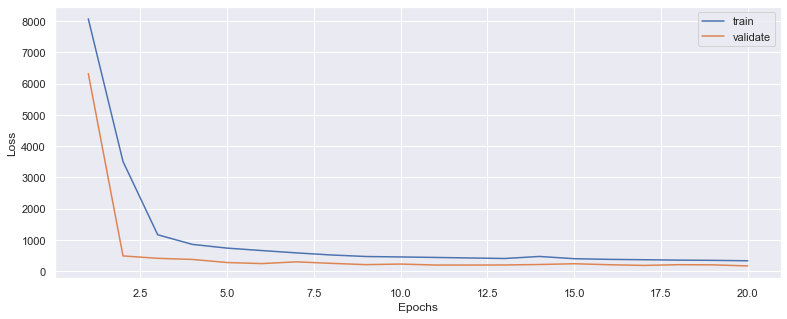

In [60]:
plot_loss(history)

In [61]:
y_hat_train = model.predict(train_array)
get_rmse(train_array_labels, y_hat_train, 'train')

y_hat_test = model.predict(test_array)
get_rmse(y_test, y_hat_test)

Dataset: train RMSE:13.031697273254395, R2:0.9009273585867822
Dataset: test RMSE:34.69275421027824, R2:0.5838446924876588


### How to try different parameters?

In [ ]:
# get column names for the lagged data set
train_dropped_co_lagged = train_dropped_co.copy()

for i in lags:
    train_dropped_co_lagged = lag(train_dropped_co_lagged, i, keep)
    
train_dropped_co_lagged.head()

features_with_lags = train_dropped_co_lagged.columns
features_with_lags = features_with_lags.drop(["unit_id", "time_cycles", "RUL", "op_cond", "setting_1", "setting_2", "setting_3"])
features_with_everything = train_dropped_co_lagged.columns
features_with_everything = features_with_everything.drop(["unit_id", "time_cycles", "RUL", "op_cond"])

In [ ]:
# can we possibly do hyperparamaterization?
lags = [1,2,3,4,5,10,20]
sequences = [np.arange(10,45,5)]
epochs = [np.arange(5,30,5)]
nodes_list = [[50], [64], [128], [256], [32, 64], [64, 128], [50,100] [128, 256]]
dropouts = list(np.arange(1,5)/10)
function = ["sigmoid", "tanh", "relu"]
batch_size = [32, 64, 128, 256]
features = [features_just_senors, features_with_settings, features_with_lags, features_with_everything]
scaling = ["conditional", "scalar", "minmax"]
gss_params = [2,3]
data_set = [train_dropped_co, train_dropped_co_lagged]

# yikes thats a lot of things I could vary
tuning_params = len(lags)*len(sequences)*len(epochs)*len(nodes_list)*len(dropouts)*len(function)*len(batch_size)*len(features)*len(scaling)*len(gss_params)*len(dataset)
tuning_params

In [ ]:
## ok lagged did NOT do better on the 50 length sequence!!
# Let's try some hyper-parameter tuning
# there are something like 100,000 possible configurations for the model, and all I have is
# my poor lenovo here

# as inspired by the azure team and other examples, I'm gonna just try some random sampling
# of params and pick the best performing one

# for data, lets use _, which so far has worked the best
# keep sequence length at 50, as that's the goal




# so first we need to set how long our sequence is going to be
# in theory this is something we can play around with
sequence_length = 50

# also, added some clipping so that I don't capture steady state operations, and instead we are looking at degredation
train['RUL'].clip(upper=125, inplace=True)

# next, drop the columns we ain't gonna be using
train_dropped = train.drop(drops, axis=1)
test_dropped = test.drop(drops, axis=1)

# now, add operating condition as a string we can use as a conditional variable
# basically just combine the settings into a single string

train_dropped_co = add_op_co(train_dropped)
test_dropped_co = add_op_co(test_dropped)

# next we need to standardize the data
scaler = StandardScaler()



# using the condition to standardize. Initially just tried scaling everything, but this actually worked the best
for co in train_dropped_co['op_cond'].unique():
    scaler.fit(train_dropped_co.loc[train_dropped_co['op_cond']==co, keep])
    train_dropped_co.loc[train_dropped_co['op_cond']==co, keep] = scaler.transform(train_dropped_co.loc[train_dropped_co['op_cond']==co, keep])
    test_dropped_co.loc[test_dropped_co['op_cond']==co, keep] = scaler.transform(test_dropped_co.loc[test_dropped_co['op_cond']==co, keep])

# regular old scalar
train_dropped_co_reg_st = train_dropped_co.copy()
test_dropped_co_reg_st = test_dropped_co.copy()
for i in keep:
    train_dropped_co_reg_st[keep] = scaler.fit_transform(train_dropped_co[keep])
    test_dropped_co_reg_st[keep] = scaler.fit_transform(test_dropped_co[keep])

# minmax, which is what Azure team did

train_dropped_co_reg_mm = train_dropped_co.copy()
test_dropped_co_reg_mm = test_dropped_co.copy()
minmax = MinMaxScaler()
for i in keep:
    train_dropped_co_reg_mm[keep] = minmax.fit_transform(train_dropped_co[keep])
    test_dropped_co_reg_mm[keep] = minmax.fit_transform(test_dropped_co[keep])

# need to now split into train and validation sets. GSS is a pretty neat way to do it, given that we need to keep units intact (i.e. sequences stay within engine)
train_u = []
val_u = []
for train_index, val_index in gss.split(train_dropped_co['unit_id'].unique(), groups=train_dropped_co['unit_id'].unique()):
    train_u = [train_index]
    val_u = [val_index]

# these are the units we are gonna use in each split
train_units = train_dropped_co['unit_id'].unique()[train_u]
val_units = test_dropped_co['unit_id'].unique()[val_u]
print(train_units)

# now we need to shape the data into arrays and then sequences for the LSTM
# tried to use tensorflow, but it does not have enough flexibility to make the sequences
# since we need to keep engine data together

# define our feature columns:
# couple different ways to look at it

features_just_senors = keep
features_with_settings = setting_names.extend(keep)

# use generator to make generator for each engine, then wrap them up into a single generator

# first make validation testing sets

train_split_gen = (list(gen_train_seq(train_dropped_co[train_dropped_co["unit_id"]==u], sequence_length, features_just_senors)) for u in train_units)
train_split = np.concatenate(list(train_split_gen)).astype(np.float32)

val_split_gen = (list(gen_train_seq(train_dropped_co[train_dropped_co["unit_id"]==u], sequence_length, features_just_senors)) for u in val_units)
val_split = np.concatenate(list(val_split_gen)).astype(np.float32)

# lstm aslo requires labels for each sequence, which needs to be generated
# label is essentially the thing we are trying to predict or classify
# in Azure study, they classified based on if the engine would fail within x cycles
# since we are trying to predict RUL, we will use RUL

train_labels_gen = [label_generator(train_dropped_co[train_dropped_co["unit_id"]==u], sequence_length, ['RUL']) for u in train_units]
train_labels = np.concatenate(list(train_labels_gen)).astype(np.float32)

val_labels_gen = [label_generator(train_dropped_co[train_dropped_co["unit_id"]==u], sequence_length, ['RUL']) for u in val_units]
val_labels = np.concatenate(list(val_labels_gen)).astype(np.float32)

# Lastly, lets get the data for making predictions, using the full available dataset

train_gen = (list(gen_train_seq(train_dropped_co[train_dropped_co["unit_id"]==u], sequence_length, features_just_senors)) for u in train_dropped_co["unit_id"].unique())
train_array = np.concatenate(list(train_gen)).astype(np.float32)

train_labels_out_gen = [label_generator(train_dropped_co[train_dropped_co["unit_id"]==u], sequence_length, ['RUL']) for u in train_dropped_co["unit_id"].unique()]
train_array_labels = np.concatenate(list(train_labels_out_gen)).astype(np.float32)

# and now we need the test data
# in order to get more test data, we can add padding to get more sequences
# padding idea inspired by --> https://towardsdatascience.com/lstm-for-predictive-maintenance-of-turbofan-engines-f8c7791353f3

test_gen = (list(test_padding(test_dropped_co[test_dropped_co["unit_id"]==u], sequence_length, features_just_senors, -99.)) for u in test_dropped_co["unit_id"].unique())
test_array = np.concatenate(list(test_gen)).astype(np.float32)

In [ ]:
# params to vary:


itterations = 20

epochs = [np.arange(10,40,5)]
nodes_list = [[50], [75], [100], [200], [50,100], [150, 250]]
dropouts = list(np.arange(1,5)/10)
function = ["sigmoid", "tanh", "relu"]

total_options = len(epochs)* len(nodes_list)*len(dropouts)* len(function)

ouput = []

# use the original block for building the sequences

for i in interations:
    
    model = Sequential()
    model.add(Masking(mask_value=-99., input_shape=(sequence_length, train_array.shape[2])))
    model.add(LSTM(node, activation=fun)
    model.add(Dense(1))

    model.compile(loss='mean_squared_error', optimizer='adam')
    history = model.fit(train_split, train_labels,
                    validation_data=(val_split, val_labels),
                    epochs=20,
                   batch_size=32)
    
    y_hat_train = model.predict(train_array)
    get_rmse(train_array_labels, y_hat_train, 'train')

    y_hat_test = model.predict(test_array)
    get_rmse(y_test, y_hat_test)
              
    output.append([[i],[node,fun,]])

### Best Model